## Pipeline

1. use initial centroid
2. crop image using np.copy
3. find centroid
4. do photometry

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmaps

from photutils import aperture_photometry
from photutils import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from photutils import centroid_com, centroid_1dg, centroid_2dg
from astropy.stats import sigma_clipped_stats
import pandas as pd
from astropy.table import Table


def get_median(file_list, n_slices, show_image=None, save_image=None):
    '''
    stack n or all object images and returns stacked image
    '''
    obj_filenames = []
    
    for i in file_list:
        z = pf.open(i)
        hdr = z[0].header
        if hdr['OBJECT']  == 'HAT-P-44':
            obj_filenames.append(i)

    # take 1457/n_slices = 30 images
    print('Stacking {0} images'.format(len(obj_filenames[::n_slices])))

    objs = np.array([pf.getdata("%s" % n) for n in obj_filenames[::n_slices]])

    print('Shape of array to be stacked: {0}'.format(objs.shape))
    objs_stacked = np.median(objs, axis=0)
    
    fig = plt.figure(figsize=(10,10))
    
    if show_image is None: #default
        norm = ImageNormalize(stretch=SqrtStretch())
        plt.imshow(objs_stacked,cmap='Greys', origin='lower', norm=norm)
        plt.show()
    
    if save_image is True: #False by default
        fname='obj_med'+n_slices+'.fits'
        print('Saving stacked image as {}'.format(fname))
        pyfits.writeto(fname, objs_stacked, header=hdr)
    
    return objs_stacked

def get_sources(image, num_sources=None, sigma_clip=None):
    '''
    returns positions of point sources
    '''
    
    median, std = np.median(image), np.std(image)
    if num_sources is None:
        num_sources=10
        #print('---showing 10 brightest sources (default)---')
        
    if sigma_clip is None:
        mean, median, std = sigma_clipped_stats(image, sigma=5, iters=5)
    else: #c.f. if sigma_clip:?
        mean, median, std = sigma_clipped_stats(image, sigma=sigma_clip, iters=5)
        
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
    sources = daofind(image - median)
    
    #get brightest sources
    sources = get_peak_sources(sources, num_sources)
    print('Top {0} brightest point sources:\n{1}'.format(num_sources,sources[:num_sources]))
    
    return sources

def get_peak_sources(sources, num_sources=None):
    '''
    returns top sources 
    '''
    #convert astropy tables to pandas.df to get sort by sources by peak
    df = sources.to_pandas()
    #df.set_index('id')
    
    if num_sources is None:
        #use pd to sort point sources by the peak column
        sources_df = df.sort_values(by='flux', ascending=False).head(3)
    else:
        sources_df = df.sort_values(by='flux', ascending=False).head(num_sources)
        
    #convert pandas back to astropy tables as required by CircularAperture() in show_sources()
    peak_sources = Table.from_pandas(sources_df)

    return peak_sources #in table format

def show_sources(image, sources, aperture_radius_pix, num_sources=None, show_image=None):
    '''
    returns (x,y) centroid positions and apertures
    '''
    if num_sources is None:
        #default shows all 10 brightest sources
        #print('---showing 10 brightest sources (default)---')
        positions = (sources['xcentroid'], sources['ycentroid'])
    else: #c.f. if num_sources:?
        positions = (sources['xcentroid'][:num_sources], sources['ycentroid'][:num_sources])
        
    apertures = CircularAperture(positions, r=aperture_radius_pix)
    
    if show_image is True:
        fig = plt.figure(figsize=(10,10))
        norm = ImageNormalize(stretch=SqrtStretch())
        plt.imshow(image, cmap='Greys', origin='lower', norm=norm)
        apertures.plot(color='blue', lw=1.5, alpha=0.5)
        #label point sources
        x,y = positions
        count=0
        for i,j in zip(x,y):
            count+=1
            plt.annotate(count,xy=(i,j), xytext=(i+10,j+10), fontsize=20)
        plt.show()
    
    return positions, apertures

def get_crop_images(image, sources, num_sources, box_size, aperture_radius_pix, show_image=None):
    '''
    returns cropped top point sources and their centroids
    '''
    #get only the top 5 brightest sources
    sources=sources[:num_sources]
    
    positions = (sources['xcentroid'], sources['ycentroid'])
    fluxes = []
    
    #apertures = CircularAperture(positions, r=aperture_radius_pix)
    
    x,y = positions
    
    column = 0
    source_images = []
    apertures = []
    
    if show_image is True:
        fig, ax = plt.subplots(nrows=1, ncols=num_sources, figsize=(10,10))
        
    for i,j in zip(x,y):
        #print(i,j)
        point_source = np.copy(image[int(j-(box_size/2)):int(j+(box_size/2)),int(i-(box_size/2)):int(i+(box_size/2))]) #y1:y2,x1:x2
        source_images.append(point_source)
        
        #mini_sources = get_centroid(image, aperture_radius_pix)
        xcenter, ycenter, aperture = get_centroid(point_source, aperture_radius_pix)
        apertures.append(aperture)
            
        if show_image is True:
            norm = ImageNormalize(stretch=SqrtStretch())
            ax[column].imshow(point_source, cmap='Greys', origin='lower', norm=norm)
            ax[column].plot(xcenter, ycenter, color='red', marker='+', ms=30, mew=2)
            
            #get_phot(mini_images)
            #ax[column].set_title('flux={0:.2f}'.format(mini_sources['fluxes']))
            aperture.plot(color='blue', lw=1.5, alpha=0.5, ax=ax[column])
            column+=1
        
    return source_images, apertures, fluxes

def get_centroid(image, aperture_radius_pix):
    xcenter, ycenter = centroid_2dg(image)
    centroid = ([xcenter, ycenter])
    aperture = CircularAperture(centroid, r=aperture_radius_pix)
    
    return xcenter, ycenter, aperture

def get_phot(mini_images):
    '''
    returns phot table
    '''
    std = np.std(mini_images)
    daofind = DAOStarFinder(fwhm=3.0, threshold = 5.*std)
    mini_sources = daofind(mini_images) #(img - median)
    #mini_sources = mini_sources.to_pandas()
        
    return mini_sources

In [4]:
%matplotlib inline
from glob import glob
import pyfits as pf

#filedir='/media/jpdl/B838B30438B2C124/df_HATP44/'
filedir='/mnt/B838B30438B2C124/df_HATP44/'
file_list = glob(filedir+'*.fits') 
file_list.sort()

Stacking 15 images
Shape of array to be stacked: (15, 1024, 1024)


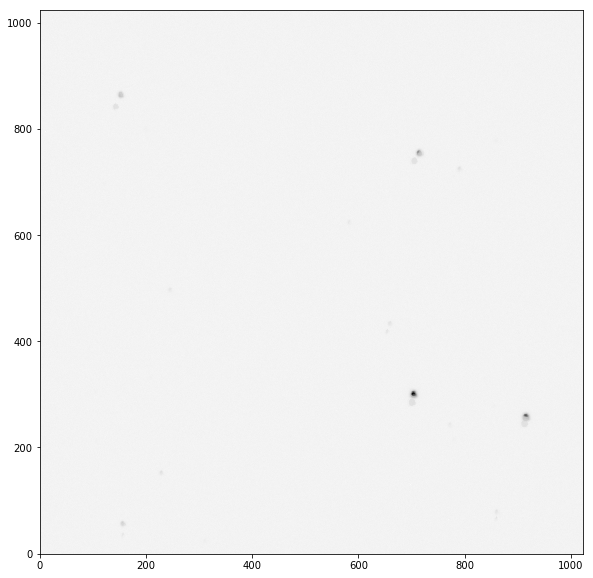

In [6]:
objs_stacked = get_median(file_list, n_slices=100, save_image=False)

In [7]:
#get top 5 sources; default saves up to 10 brightest sources
sources= get_sources(objs_stacked, num_sources=10, sigma_clip=5)

Top 10 brightest point sources:
 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
 20 702.180872909 301.834528054 ... 21737.8867188 51.0687100603 -4.27038722048
 15 913.935281252 260.487089306 ... 13603.8378906 36.6339522699  -3.9097094381
 37 149.827085405 862.632186251 ...  2590.3515625 5.01284508928 -1.75021070981
  6 154.794492019 58.3825024454 ... 1716.14453125 3.70848067833 -1.42299005156
 39 151.412015778 868.567217109 ... 1505.83398438 3.31382795626 -1.30082489359
 14 917.758121072  256.21509314 ... 1998.19335938 3.17929144754 -1.25582585443
 13 915.937240159 252.264513253 ... 1915.31445312   2.789805679   -1.113934885
 32 718.267199385 752.553708497 ... 1768.73046875 2.73268733571 -1.09147486029
 38 153.581204165 862.005776849 ...  1828.4140625 2.67954989651 -1.07015462138
 19 708.387362545 297.288798278 ... 3452.05859375 2.59576659628 -1.03566409849


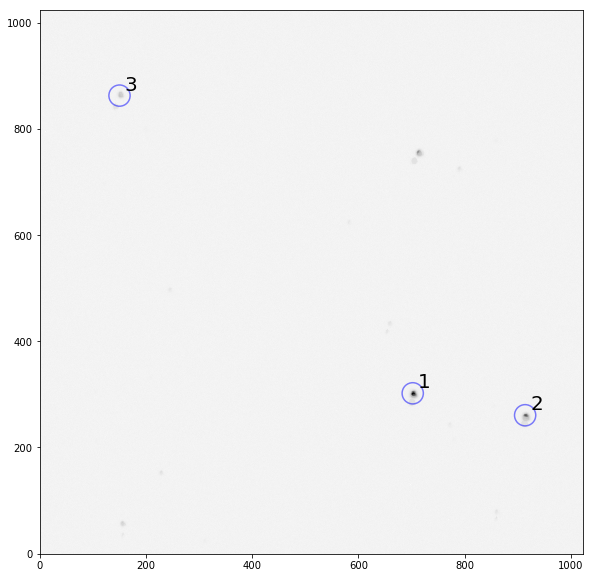

In [8]:
positions, apertures = show_sources(objs_stacked, sources, num_sources=3, aperture_radius_pix=20, show_image=True)

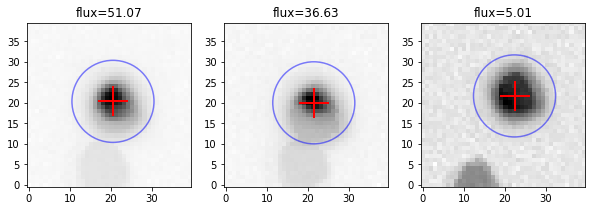

In [22]:
source_images, apertures = get_crop_images(objs_stacked, sources, num_sources=3, aperture_radius_pix=10, box_size=40, show_image=True)

## Aperture Photometry

In [27]:
#this step essentially uses get_sources()
phot_table = get_phot(source_images)

#[get_sources(i, num_sources=3) for i in source_images]

## Make lightcurve

In [25]:
from datetime import datetime

datetime.strptime(hdr['DATE-OBS'], '%Y-%m-%d')

datetime.datetime(2017, 2, 15, 0, 0)

In [21]:
hdr['MJD-STRT']

57799.8740914464

In [ ]:
from datetime import datetime as dt

obj_time = []
obj_mjd  = []

#initial values obtained from from stacked image:
init_centroid = (sources['xcentroid'], sources['ycentroid'])
box_size=20
phot_tables=[]
fluxes = []

for i in file_list[::300]:
    z = pf.open(i)
    hdr = z[0].header
    img = z[0].data
    if hdr['OBJECT']  == 'HAT-P-44':
        date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
        time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
        newdate = time.replace(year=date.year, month=date.month, day=date.day)
        obj_time.append(newdate)
        obj_mjd.append(hdr['MJD-STRT'])
        
        positions, apertures = show_sources(img, sources, aperture_radius_pix=10,show_image=False)
        source_images, apertures, flux = get_crop_images(img, sources, num_sources=3, aperture_radius_pix=10, box_size=80, show_image=True)
        
        fluxes.append(flux)

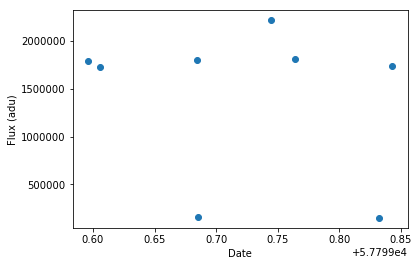

In [160]:
flux_adu = []

for i in range(len(phot_tables)):
    flux_adu.append(phot_tables[i]['aperture_sum'][0])
    
#plt.plot(obj_time,flux_adu, 'o')
plt.plot(obj_mjd,flux_adu, 'o')
plt.ylabel('Flux (adu)')
plt.xlabel('Date')

In [ ]:
num_sources=3

flux_adu = []

for i in range(len(phot_tables)):
    flux_adu.append(phot_tables[i]['aperture_sum'][:num_sources])
    
fig, ax = plt.subplots(nrows=1,ncols=num_sources,figsize=(15,5))

for i in range(num_sources):
    ax[i].plot(obj_mjd,flux_adu[i], 'o')
    #plt.plot(obj_time,flux_adu[i], 'o')
    ax[i].set_ylabel('Flux (adu)')
    ax[i].set_xlabel('Date')

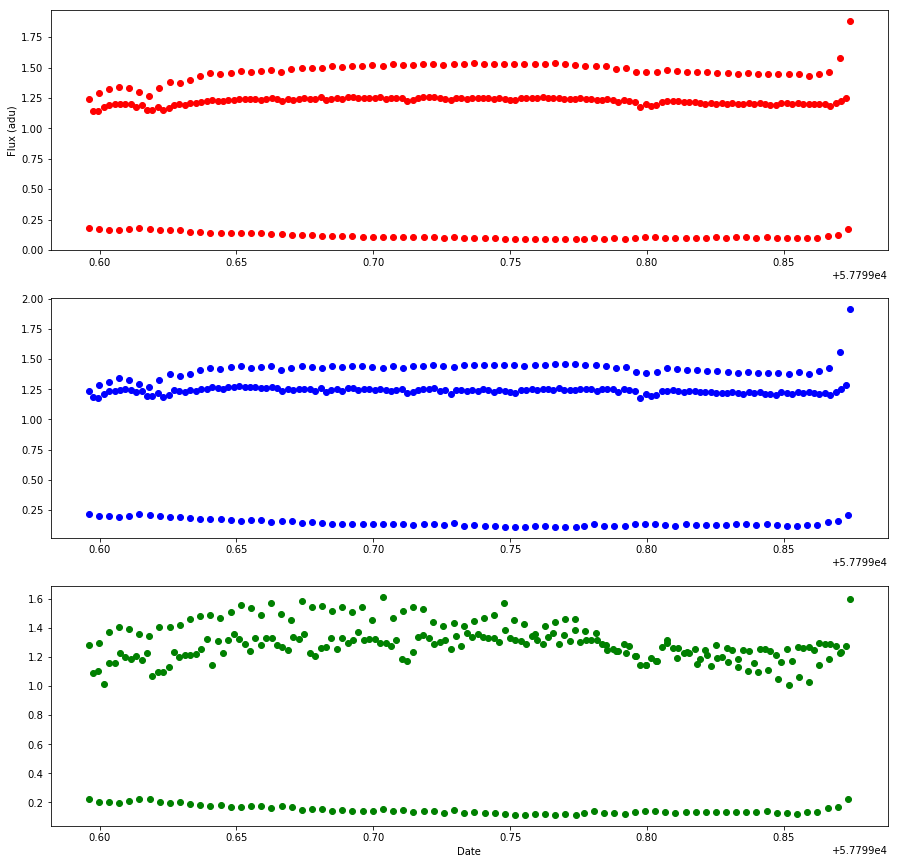

In [38]:
'''
  id   xcentroid     ycentroid   ...      peak          flux           mag      
  --- ------------- ------------- ... ------------- ------------- ---------------
  1 817.924729635 17.6246340694 ...   199.0546875 1.23201281266 -0.226538061043
  2 156.110302174 37.4092066052 ... 495.150390625 2.51339377608  -1.00065133826
  3 154.940375202 55.6764102917 ... 1242.12695312 2.58603731411  -1.03158696764
'''
%matplotlib inline

from datetime import datetime as dt
from glob import glob
import pyfits as pf

filedir='/media/jpdl/B838B30438B2C124/df_HATP44/'
file_list = glob(filedir+'*.fits') 
file_list.sort()

obj_time = []
obj_mjd  = []

#initial values obtained from from stacked image:
init_centroid = (sources['xcentroid'], sources['ycentroid'])
box_size=20
phot_tables=[]

for i in file_list[::5]:
    z = pf.open(i)
    hdr = z[0].header
    img = z[0].data
    if hdr['OBJECT']  == 'HAT-P-44':
        date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
        time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
        newdate = time.replace(year=date.year, month=date.month, day=date.day)
        obj_time.append(newdate)
        obj_mjd.append(hdr['MJD-STRT'])
        
        #sources= Get_Sources(img, num_sources=5, sigma_clip=5)
        #sources = Get_Peak_Sources(sources, num_sources=5)
        positions, apertures = Show_Sources(img, sources, aperture_radius_pix=10,show_image=False)
        source_images = Get_Crop_Images(img, sources, num_sources=3, aperture_radius_pix=10, box_size=40, show_image=False)
        phot_tables.append(aperture_photometry(img, apertures))
        
flux_adu1 = []
flux_adu2 = []
flux_adu3 = []

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))

for i in range(len(phot_tables)):
    flux_adu1.append(phot_tables[i]['aperture_sum'][0])
    flux_adu2.append(phot_tables[i]['aperture_sum'][1])
    flux_adu3.append(phot_tables[i]['aperture_sum'][2])
    
ax[0].plot(obj_mjd,flux_adu1/np.mean(flux_adu1), 'ro')
ax[1].plot(obj_mjd,flux_adu2/np.mean(flux_adu2), 'bo')
ax[2].plot(obj_mjd,flux_adu3/np.mean(flux_adu3), 'go')
ax[0].set_ylabel('Flux (adu)')
ax[2].set_xlabel('Date')

In [19]:
# C6/EPIC-212480208b
import astropy.units as u

rstar = 0.813
scaled_a=21.0377
teff=5579
k=0.0083

r_p=k*rstar*110
a_au = scaled_a * rstar * u.R_sun.to(u.au)

T_eq= 270 * (teff/5780.) * (rstar/a_au) **0.5
print('r_p={0};\nT_eq={1}'.format(r_p, T_eq))

r_p=0.742269;
T_eq=833.3065575104902


In [23]:
R_E=6371
R_mars=3390
0.742269*R_E/R_mars

1.3949840115044245

## PSF Modeling

In [ ]:
sample



In [44]:
ygrid, xgrid = np.mgrid[:sample.shape[0], :sample.shape[1]]

for i in range(sample.shape[0]):
    for j in range(sample.shape[1]):
        xgrid[i,j] = sample[i][j]
        ygrid[i,j] = sample[j][i]

In [28]:
np.std(sample)

1465.7274

In [38]:
x

array([[ 0,  1,  2, ..., 37, 38, 39],
       [ 0,  1,  2, ..., 37, 38, 39],
       [ 0,  1,  2, ..., 37, 38, 39],
       ..., 
       [ 0,  1,  2, ..., 37, 38, 39],
       [ 0,  1,  2, ..., 37, 38, 39],
       [ 0,  1,  2, ..., 37, 38, 39]])

In [35]:
xgrid

array([[938, 928, 940, ..., 895, 975, 908],
       [931, 968, 943, ..., 935, 908, 940],
       [934, 912, 937, ..., 927, 912, 950],
       ..., 
       [922, 947, 972, ..., 911, 957, 911],
       [925, 936, 944, ..., 930, 932, 956],
       [910, 926, 952, ..., 934, 937, 909]])

In [30]:
y

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  2,  2],
       ..., 
       [37, 37, 37, ..., 37, 37, 37],
       [38, 38, 38, ..., 38, 38, 38],
       [39, 39, 39, ..., 39, 39, 39]])

In [37]:
ygrid

array([[938, 931, 934, ..., 922, 925, 910],
       [928, 968, 912, ..., 947, 936, 926],
       [940, 943, 937, ..., 972, 944, 952],
       ..., 
       [895, 935, 927, ..., 911, 930, 934],
       [975, 908, 912, ..., 957, 932, 937],
       [908, 940, 950, ..., 911, 956, 909]])

In [45]:
sigma_y, sigma_x = np.std(ygrid), np.std(xgrid)

zgrid = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-(x**2/(2*sigma_x**2)
     + y**2/(2*sigma_y**2))))

see [2-D model fitting with astropy](http://docs.astropy.org/en/stable/modeling/); see also scipy [interpolate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html); astropy [2DGaussian kernel](http://docs.astropy.org/en/stable/convolution/kernels.html); astroml [robust bivariate gaussian estimation](http://www.astroml.org/book_figures/chapter3/fig_robust_pca.html)

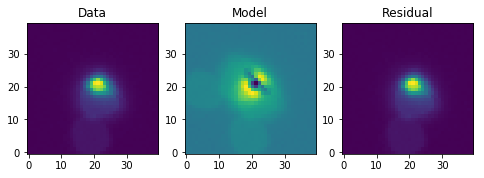

In [46]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

# Fit the data using astropy.modeling
p_init = models.Polynomial2D(degree=2)
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, xgrid, ygrid, zgrid)

# Plot the data with the best-fit model
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(sample, origin='lower', interpolation='nearest')
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(xgrid, ygrid), origin='lower', interpolation='nearest')
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(sample - p(xgrid, ygrid), origin='lower', interpolation='nearest')
plt.title("Residual")

## PSF

In [ ]:
from glob import glob
import pyfits as pf
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import numpy as np


class LightCurve():
    def __init__(self):
    #
    #
    self.synaptic_weights = 2 * random.random((3,1)) - 1
    
    #Sigmoid function: S-shaped curve
    #we pass the weighted sum of the inputs through this function
    #to normalize them between 0 and 1
    def __sigmoid(self, x):
	return 1.0/(1 + exp(-x))
    
    #gradient of the sigmoid curve
    def __sigmoid_derivative(self, x):
	return x * (1-x)

    def train(self, training_set_inputs, training_set_outputs, number_of_training_iterations):
    	for iterations in xrange(number_of_training_iterations):
	    #pass the training set through our NN
	    output = self.predict(training_set_inputs)
	    #calculate the error
	    error = training_set_outputs - output
	    #multiply the error by the input and by the gradient of sigmoid curve
	    adjustment = dot(training_set_inputs.T, error * self.__sigmoid_derivative(output))
	    #adjust the weights
	    self.synaptic_weights += adjustment
    def predict(self, inputs):
	#pass inputs through our NN
	return self.__sigmoid(dot(inputs, self.synaptic_weights))


if __name__ == '__main__':
    #initialize
    lightcurve = LightCurve()
    print 'Random starting synaptic weights:'
    print neural_network.synaptic_weights

    #Training set: try 4 samples each consisting of 3 input value and 1 output value
    training_set_inputs = array([[0,0,1],[1,1,1],[1,0,1],[0,1,1]])
    training_set_outputs = array([[0,1,1,0]]).T

    #train the NN using a training set
    #do it 10000 times and make small adjustments each time
    neural_network.train(training_set_inputs, training_set_outputs, 10000)

    print 'New synaptic weights after training:'
    print neural_network.synaptic_weights

    #test the NN
    print 'predicting:'
    print neural.network.predict([0,1,0])

Test

In [ ]:
def get_crop_images(image, sources, num_sources, box_size, aperture_radius_pix, show_image=None):
    '''
    returns cropped top point sources and their centroids
    '''
    #get only the top 5 brightest sources
    sources=sources[:num_sources]
    
    positions = (sources['xcentroid'], sources['ycentroid'])
    
    #apertures = CircularAperture(positions, r=aperture_radius_pix)
    
    x,y = positions
    
    column = 0
    source_images = []
    apertures = []
    
    if show_image is True:
        fig, ax = plt.subplots(nrows=1, ncols=num_sources, figsize=(10,10))
        
    for i,j in zip(x,y):
        #print(i,j)
        point_source = np.copy(image[int(j-(box_size/2)):int(j+(box_size/2)),int(i-(box_size/2)):int(i+(box_size/2))]) #y1:y2,x1:x2
        source_images.append(point_source)
        
        #get centroid
        xcenter, ycenter, aperture = get_centroid(point_source, aperture_radius_pix)
        apertures.append(aperture)
            
        if show_image is True:
            norm = ImageNormalize(stretch=SqrtStretch())
            ax[column].imshow(point_source, cmap='Greys', origin='lower', norm=norm)
            ax[column].plot(xcenter, ycenter, color='red', marker='+', ms=30, mew=2)
            ax[column].set_title('flux={0:.2f}'.format(sources['flux'][column]))
            aperture.plot(color='blue', lw=1.5, alpha=0.5, ax=ax[column])
            column+=1
        
    return source_images, apertures